In [1]:
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

dbPath = r"C:\Users\Utilisateur\local_SIMPLON\SIMPLON_prairie\Brief 12012024 Développer une API REST pour exposer un modèle prédictif avec des données immobilières\dataSources"

In [2]:
path = pathlib.Path(dbPath)

arrays = dict(np.load(path / "transactions.npz"))
data = {k: [s.decode("utf-8") for s in v.tobytes().split(b"\x00")] if v.dtype == np.uint8 else v for k, v in arrays.items()}
df_transactions = pd.DataFrame.from_dict(data)

df_transactions.to_csv(r"dataSources\transactions.csv", header=True)

In [3]:
df_transactions = pd.read_csv(r'dataSources\transactions.csv')

if 'Unnamed: 0' in df_transactions.columns:
    df_transactions = df_transactions.drop('Unnamed: 0', axis=1)
    
df_transactions['prix_m2'] = df_transactions['prix'] / (df_transactions['surface_habitable'])

In [4]:
df_idf = df_transactions[(df_transactions.departement.isin([75, 77, 78, 91, 92, 93, 94, 95])) &
                         (df_transactions.date_transaction.str.startswith('2022')) &
                         (df_transactions.type_batiment == 'Appartement') &
                         (df_transactions.prix_m2 < 20000)]

surface_cols = [c for c in df_idf.columns if 'surface_' in c and c != 'surface_habitable']

for c in surface_cols:
    df_idf[c + '_sum'] = df_idf[c].apply(lambda x: sum(eval(x)) if 'NULL' not in x else 0)

df_idf = df_idf[df_idf[[c + '_sum' for c in surface_cols]].sum(axis=1) == 0]

display(df_idf)

,id_transaction,date_transaction,prix,departement,id_ville,ville,code_postal,adresse,type_batiment,vefa,...,surface_locaux_industriels,surface_terrains_agricoles,surface_terrains_sols,surface_terrains_nature,prix_m2,surface_dependances_sum,surface_locaux_industriels_sum,surface_terrains_agricoles_sum,surface_terrains_sols_sum,surface_terrains_nature_sum
6043985,10040024,2022-01-03,329910.0,75,112,PARIS 12,75012,260 AV DAUMESNIL,Appartement,False,...,{},{},{},{},10997.000000,0,0,0,0,0
6043986,10035062,2022-01-03,302400.0,75,102,PARIS 02,75002,52 RUE GRENETA,Appartement,False,...,{},{},{},{},11630.769231,0,0,0,0,0
6043987,10036657,2022-01-03,665000.0,75,117,PARIS 17,75017,26 BD DES BATIGNOLLES,Appartement,False,...,{},{},{},{},11271.186441,0,0,0,0,0
6043988,10035700,2022-01-03,965000.0,75,105,PARIS 05,75005,31 RUE CENSIER,Appartement,False,...,{},{},{},{},15317.460317,0,0,0,0,0
6043989,10029380,2022-01-03,200000.0,75,110,PARIS 10,75010,37 RUE DE PARADIS,Appartement,False,...,{},{},{},{},10526.315789,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8228478,13363983,2022-12-30,195000.0,95,127,CERGY,95000,2 RUE HAUTE DU TERTRE,Appartement,False,...,{},{},{},{},2407.407407,0,0,0,0,0
8228482,13367769,2022-12-30,268000.0,95,149,CHAUMONTEL,95270,2 RUE DE L ORME,Appartement,False,...,{},{},{},{},3941.176471,0,0,0,0,0
8228484,13363140,2022-12-30,129500.0,95,252,FRANCONVILLE LA GARENNE,95130,2 RUE DES FOLLES ENTREPRISES,Appartement,False,...,{},{},{},{},2443.396226,0,0,0,0,0
8228486,13367058,2022-12-30,635000.0,95,428,MONTMORENCY,95160,1 RUE DES SABLONS,Appartement,False,...,{},{},{},{},6546.391753,0,0,0,0,0


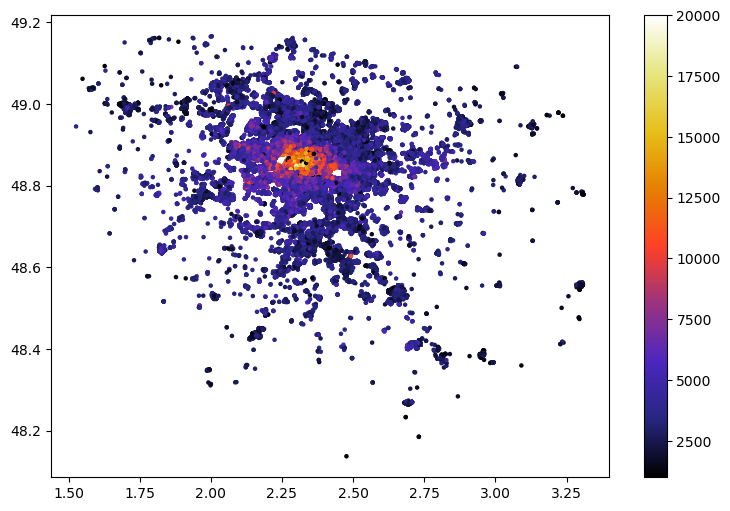

In [10]:
#df_idf.prix_m2.hist(bins=80)
colors = np.array(df_idf['prix_m2'])
plt.figure(figsize=(9,6))
plt.scatter(df_idf['longitude'],df_idf['latitude'], c=colors, vmin=1000, vmax=20000, cmap='CMRmap', s=5)
plt.colorbar()
plt.show()


In [6]:
with open(r"dataFrames\df_idf.pkl", "wb") as f:
    my_pickler = pickle.Pickler(f)
    my_pickler.dump(df_idf)